Problem: 
Context
Bob has started his own mobile company. He wants to give tough fight to big companies like Apple,Samsung etc.

He does not know how to estimate price of mobiles his company creates. In this competitive mobile phone market you cannot simply assume things. To solve this problem he collects sales data of mobile phones of various companies.

Bob wants to find out some relation between features of a mobile phone(eg:- RAM,Internal Memory etc) and its selling price. But he is not so good at Machine Learning. So he needs your help to solve this problem.

In this problem you do not have to predict actual price but a price range indicating how high the price is 

In [ ]:
import pandas as pd
import sklearn 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv("train.csv")

In [ ]:
data

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,14,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,3,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,3,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,5,336,670,869,18,10,19,1,1,1,0


In [ ]:
nans = []
for c in data.columns:
  nans.append(data.loc[pd.isna(data[c]) == True][c].count())

nans_for_columns = pd.DataFrame(data = {"Column name": data.columns, "Number of nans": nans})
nans_for_columns

,Column name,Number of nans
0,battery_power,0
1,blue,0
2,clock_speed,0
3,dual_sim,0
4,fc,0
5,four_g,0
6,int_memory,0
7,m_dep,0
8,mobile_wt,0
9,n_cores,0


As we can see, this dataset is empty of nans values, and this condition allow us go forward whithout to do any change

In [ ]:
data["price_range"].unique()

array([1, 2, 3, 0])

The numbers of categories over the response variable is 4. 

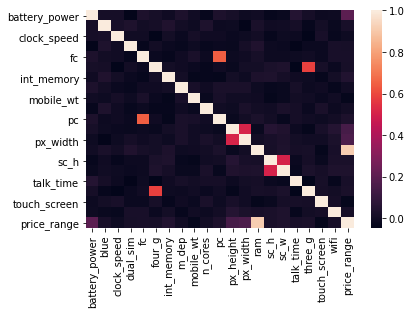

In [ ]:
sbn.heatmap(data.corr(), corner = True)

Seems be that the variable ram is strongly correlationated with price_range

In [ ]:
model_FA = FactorAnalysis(n_components = 2)
X_continuos = data.drop(["blue", "dual_sim", "four_g", "wifi", "three_g", "touch_screen", "price_range"], axis = 1).to_numpy()
X_dummy = data[["blue", "dual_sim", "four_g", "wifi", "three_g", "touch_screen"]].to_numpy()


In [ ]:
scaler = StandardScaler()
scaler.fit(X_continuos)
X_continuos_s = scaler.transform(X_continuos)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


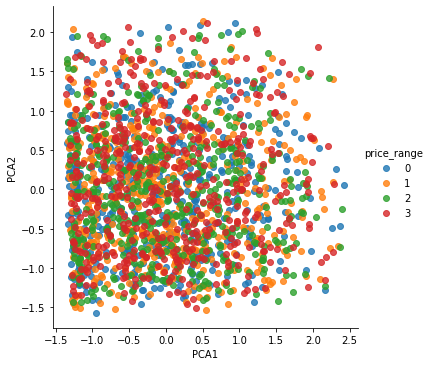

In [ ]:
X_FA = np.concatenate((X_continuos_s, X_dummy), axis = 1)
model_FA.fit(X_PCA)
X_2D = model_FA.transform(X_PCA)
data["FA1"] = X_2D[:, 0]
data["FA2"] = X_2D[:, 1]
sbn.lmplot("PCA1", "PCA2", data = data, hue = "price_range", fit_reg = False)

In the plot, we saw that each class of price_range is together with another one. That means that we need a more complicated model for to predict the price_range well.

We will choose a non parametric model. We will choose the Boosting Classifier model for to clasify the price_range correctly

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
Boosting = GradientBoostingClassifier()

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(Boosting, data.drop(["price_range"], axis = 1).to_numpy(), data["price_range"].to_numpy(), cv = 10)

In [ ]:
np.mean(scores)

0.9109999999999999

As we can see, the GradientBoostingClassifier has a mean accuracy over the 91,09%!. We will see which are the features most importants

In [ ]:
Boosting.fit(data.drop(["price_range"], axis = 1).to_numpy(), data["price_range"].to_numpy())

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

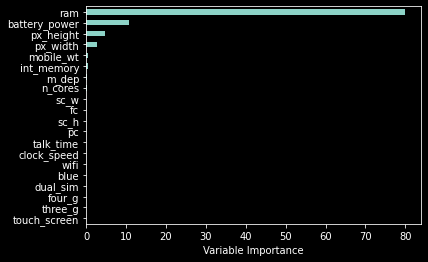

In [ ]:
Importance = pd.DataFrame({'Importance':Boosting.feature_importances_*100}, index=data.drop(["price_range"], axis = 1).columns)
with plt.style.context("dark_background"):
 Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', )
 plt.xlabel('Variable Importance')
 plt.gca().legend_ = None

In [ ]:
data_test = pd.read_csv("test.csv")
Predictions = Boosting.predict(data_test.drop(["id"], axis = 1).to_numpy())

In [ ]:
data_test["predictions"] = Predictions
data_test

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,predictions
0,1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0,3
1,2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0,3
2,3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1,2
3,4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0,3
4,5,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,1700,1,1.9,0,0,1,54,0.5,170,7,17,644,913,2121,14,8,15,1,1,0,2
996,997,609,0,1.8,1,0,0,13,0.9,186,4,2,1152,1632,1933,8,1,19,0,1,1,1
997,998,1185,0,1.4,0,1,1,8,0.5,80,1,12,477,825,1223,5,0,14,1,0,0,0
998,999,1533,1,0.5,1,0,0,50,0.4,171,2,12,38,832,2509,15,11,6,0,1,0,2


In [ ]:
data_test.to_csv("Predictions_test.csv")